# Introduction

An agreement between and insurer and policyholder that commits the insurer to paying beneficiaries a certain amount of money at the policyholder's death is known as a life insurance policy. In return, the policyholder pays premiums over a predefined period of time in exchange. 

The termination of an insurance policy as a result of the policyholder's failure to pay the premium is termed as lapse. Meanwhile policyholder may choose terminate the policy, in such case, the insurer will be required to pay a surrender charge.

To achieve long-term financial success of insurer, they need strategic management for lapse risk. In case when people who are unconfident about their health condition are left when people who typically believe they are healthy decide to lapse their coverage. There is greater chance that insurers will pay out death benefits in compare to survival group.

In the industry, using AI to automate lapse risk and to create a machine learning model that performs better than human judgement and implement it on a large scale is possible. The purpose of this research is to examine the lapse risk prediction of life insurance using historical data.

## Problem Statement

Lapse plays a crucial role on the profitability of a life insurer. Lapse risk could reduce insurance company's projected earnings. Besides, a high lapse rate may have negative impact on insurer's reputation, which could lead to additional policyholder choosing to surrender their insurance or to lapse and further, could harm the insurer's ability to attract new business.

In life insurance, accurately predicting lapse in life insurance policies and identifying influential features using traditional statistical methods might not assure reliability.

## Objectives

1. To evaluate the performance of tree-base ensemble classification models, namely XGBoost, CatBoost, Random Forest, in predicting lapse risk.
2. To assess the effectiveness of feature extracted from XG Boost with Random Forest, CatBoost, XGBoost in predicting lapse risk.

## Significance of this Study

The significance of this study lies in its potential to provide valuable insights for the life insurance industry, specifically in predicting lapse risk. Furthermore, the exploration of tree-base ensemble classification models contributes to the evolving landscape of predictive analytics in the life insurance domain, offering practical implications for insurers seeking to navigate the complexities of lapse prediction.



# Methodology

In this methodology, includes data understanding phase, data preparation, feature selection, modelling, evaluation and identifying best model.

After data preparation phase, the dataset will be partitioned into training and testing set with 80% and 20% of the dataset respectively. The testing data is used to evaluate the model's predictive ability, while the training data is used for the classification model's parameters. The parameter for the classification model is done by feature selected using satistical approach and feature extracted from XG Boost by using the training data. 

Here we are going to use Random Forest, CatBoost and XGBoost algorithm for classification model. Model testing will be carried out on all models build according to the specified algorithm. The model build be validate using accuracy, precision, recall, F-measures.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder


from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Data Collection

In [2]:
df = pd.read_csv('/kaggle/input/life-insurance-policy-data/Kaggle.csv')

In [3]:
df.shape

(185560, 20)

In [4]:
df['POLICY STATUS'].value_counts()

POLICY STATUS
Lapse        98865
Inforce      65814
Surrender    20233
Death          513
Expired        135
Name: count, dtype: int64

In [5]:
df.drop(df[df['POLICY STATUS'] == 'Expired'].index, inplace=True)
df.drop(df[df['POLICY STATUS'] == 'Surrender'].index, inplace=True)
df.drop(df[df['POLICY STATUS'] == 'Death'].index, inplace=True)

In [6]:
df.drop('Issue Date', axis=1, inplace=True)

In [7]:
df['POLICY STATUS'] = df['POLICY STATUS'].map({
    "Lapse": "LAPSE",
    "Inforce": "NOTLAPSE"
})

In [8]:
df.shape

(164679, 19)

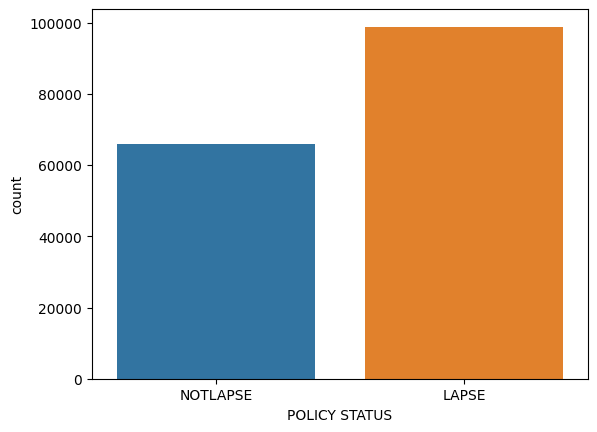

In [9]:
sns.countplot(x=df['POLICY STATUS'])
plt.show()

# Data Pre-processing

Data pre-processing in Machine Learning refers to the technique of preparing data. Here missing value of feature was identified and imputation of missing values was performed.

In [10]:
missing_stats = []
for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)

,feature,unique_values,percent_missing,percent_biggest_cat,type
18,Premium,2757,41.372610,41.372610,float64
10,BENEFIT,2569,11.994851,18.452869,float64
0,CHANNEL1,8,0.000000,59.332398,int64
2,CHANNEL3,83,0.000000,62.192508,int64
1,CHANNEL2,3,0.000000,62.191901,int64
5,POLICY TYPE 1,20,0.000000,65.533553,int64
3,ENTRY AGE,71,0.000000,3.496499,int64
6,POLICY TYPE 2,88,0.000000,20.335926,int64
7,POLICY TYPE 3,5,0.000000,41.280309,object
8,PAYMENT MODE,5,0.000000,76.021229,object


In [11]:
df.describe()

,CHANNEL1,CHANNEL2,CHANNEL3,ENTRY AGE,POLICY TYPE 1,POLICY TYPE 2,BENEFIT,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Policy Year (Decimal),Policy Year,Premium
count,164679.000000,164679.000000,164679.000000,164679.000000,164679.000000,164679.000000,1.449260e+05,164679.000000,164679.000000,164679.000000,164679.000000,164679.000000,96547.000000
mean,3.567006,2.586517,7.854505,32.225712,5.123276,22.289163,2.379973e+04,0.252707,0.000583,182.998841,3.224317,3.767615,1271.679410
std,1.990023,0.559751,13.721523,12.831399,3.640206,19.455252,6.361293e+04,5.028869,0.032872,2962.298159,1.850975,1.865154,5890.013653
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000e+01,-99.000000,0.000000,0.000000,0.000000,1.000000,-111.000000
25%,2.000000,2.000000,0.000000,25.000000,3.000000,6.000000,1.000000e+03,0.000000,0.000000,0.000000,1.750000,2.000000,131.000000
50%,2.000000,3.000000,0.000000,32.000000,3.000000,13.000000,1.300000e+04,0.000000,0.000000,0.000000,3.166667,4.000000,432.000000
75%,6.000000,3.000000,11.000000,41.000000,6.000000,37.000000,2.000000e+04,0.000000,0.000000,0.000000,4.666667,5.000000,960.000000
max,8.000000,3.000000,82.000000,70.000000,20.000000,88.000000,5.000000e+06,250.000000,5.000000,255509.957600,8.000000,9.000000,444000.000000


In [12]:
imputer_mean = SimpleImputer(strategy='median')

numeric_features = ['Premium', 'BENEFIT']
df[numeric_features] = imputer_mean.fit_transform(df[numeric_features])

In [13]:
missing_stats = []
for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)

,feature,unique_values,percent_missing,percent_biggest_cat,type
0,CHANNEL1,8,0.0,59.332398,int64
1,CHANNEL2,3,0.0,62.191901,int64
2,CHANNEL3,83,0.0,62.192508,int64
3,ENTRY AGE,71,0.0,3.496499,int64
4,SEX,2,0.0,57.735959,object
5,POLICY TYPE 1,20,0.0,65.533553,int64
6,POLICY TYPE 2,88,0.0,20.335926,int64
7,POLICY TYPE 3,5,0.0,41.280309,object
8,PAYMENT MODE,5,0.0,76.021229,object
9,POLICY STATUS,2,0.0,60.034977,object


In [14]:
df['POLICY STATUS'] = df['POLICY STATUS'].map({'LAPSE': 1, 'NOTLAPSE': 0})

In [15]:
df['POLICY STATUS'] = df['POLICY STATUS'].astype(int)

In [16]:
df.shape

(164679, 19)

In [17]:
df['POLICY STATUS'].value_counts()

POLICY STATUS
1    98865
0    65814
Name: count, dtype: int64

In [18]:
X = df.drop('POLICY STATUS', axis=1)
y = df['POLICY STATUS']

# Data Partitioning

After evaluating the result of different partition. The best fit in accuracy and other parameters specified in evaluation of the model was chosen. 

The following procedure will be followed for the data partition as 
1. Training Set: 80%
2. Test Set: 20%

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (131743, 18)
Shape of X_test: (32936, 18)
Shape of y_train: (131743,)
Shape of y_test: (32936,)


# Statistically Feature Selected

The reduction of features can also decrease the time of execution. To some extent, it can also prevent overfitting.

For statistical approach Pearson's correlation coefficient was measured for numerical feature whereas for categorial feature Chi-squared statistic was measured.

In [20]:
all_col = list(X_train.columns)
all_col_count = len(all_col)
print("Total No. of Features in the Dataset:")
print(all_col_count)

all_features = X_train.columns
print("All Features in the Dataset:")
print(all_features)

Total No. of Features in the Dataset:
18
All Features in the Dataset:
Index(['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'ENTRY AGE', 'SEX', 'POLICY TYPE 1',
       'POLICY TYPE 2', 'POLICY TYPE 3', 'PAYMENT MODE', 'BENEFIT',
       'NON LAPSE GUARANTEED', 'SUBSTANDARD RISK', 'NUMBER OF ADVANCE PREMIUM',
       'INITIAL BENEFIT', 'Full Benefit?', 'Policy Year (Decimal)',
       'Policy Year', 'Premium'],
      dtype='object')


## Pearson’s Correlation Coefficient

In the process of data selection Pearson’s Correlation Coefficient analysis was examined to find relationship between various attribute with correlation coefficient exceeding 0.5 were consider strongly correlated.


In [21]:
def color(val):
    color = 'green' if val ==1 else 'red' if val < -0.5 else 'blue' if val > 0.5 else 'black'   #write like lambda
    return 'color: %s' % color

corr = X_train[X_train.columns].select_dtypes(include=['number']).corr()
corr.style.map(color)

,CHANNEL1,CHANNEL2,CHANNEL3,ENTRY AGE,POLICY TYPE 1,POLICY TYPE 2,BENEFIT,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Policy Year (Decimal),Policy Year,Premium
CHANNEL1,1.000000,-0.730669,0.667321,0.031234,0.175363,0.214095,-0.027742,-0.014994,-0.014542,0.107079,-0.353206,-0.351509,-0.050391
CHANNEL2,-0.730669,1.000000,-0.644833,0.022751,0.012588,-0.024470,0.003636,0.006420,0.013632,0.045684,0.155843,0.159527,0.019088
CHANNEL3,0.667321,-0.644833,1.000000,-0.024285,-0.009360,0.017851,-0.038868,-0.013620,-0.010568,-0.035417,-0.219440,-0.220384,-0.044046
ENTRY AGE,0.031234,0.022751,-0.024285,1.000000,0.104000,0.116376,0.058338,0.053098,0.010058,0.057272,-0.080703,-0.079962,0.057047
POLICY TYPE 1,0.175363,0.012588,-0.009360,0.104000,1.000000,0.938628,0.106567,-0.001559,0.006946,0.136612,-0.505606,-0.495219,0.042091
POLICY TYPE 2,0.214095,-0.024470,0.017851,0.116376,0.938628,1.000000,0.091112,-0.004005,0.002873,0.117668,-0.474263,-0.465947,0.031841
BENEFIT,-0.027742,0.003636,-0.038868,0.058338,0.106567,0.091112,1.000000,0.087221,0.010728,0.033840,-0.066434,-0.067182,0.359820
SUBSTANDARD RISK,-0.014994,0.006420,-0.013620,0.053098,-0.001559,-0.004005,0.087221,1.000000,-0.000919,-0.003081,-0.003424,-0.002636,0.088690
NUMBER OF ADVANCE PREMIUM,-0.014542,0.013632,-0.010568,0.010058,0.006946,0.002873,0.010728,-0.000919,1.000000,-0.001147,-0.018768,-0.020751,0.003280
INITIAL BENEFIT,0.107079,0.045684,-0.035417,0.057272,0.136612,0.117668,0.033840,-0.003081,-0.001147,1.000000,-0.086531,-0.083274,-0.011388


In [22]:
X_train_nom = X_train[all_features].select_dtypes(include=['object'])
print(X_train_nom.columns)

Index(['SEX', 'POLICY TYPE 3', 'PAYMENT MODE', 'NON LAPSE GUARANTEED',
       'Full Benefit?'],
      dtype='object')


In [23]:
X_train_numeric = X_train[all_features].select_dtypes(include=['number'])
print(X_train_numeric.columns)

Index(['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'ENTRY AGE', 'POLICY TYPE 1',
       'POLICY TYPE 2', 'BENEFIT', 'SUBSTANDARD RISK',
       'NUMBER OF ADVANCE PREMIUM', 'INITIAL BENEFIT', 'Policy Year (Decimal)',
       'Policy Year', 'Premium'],
      dtype='object')


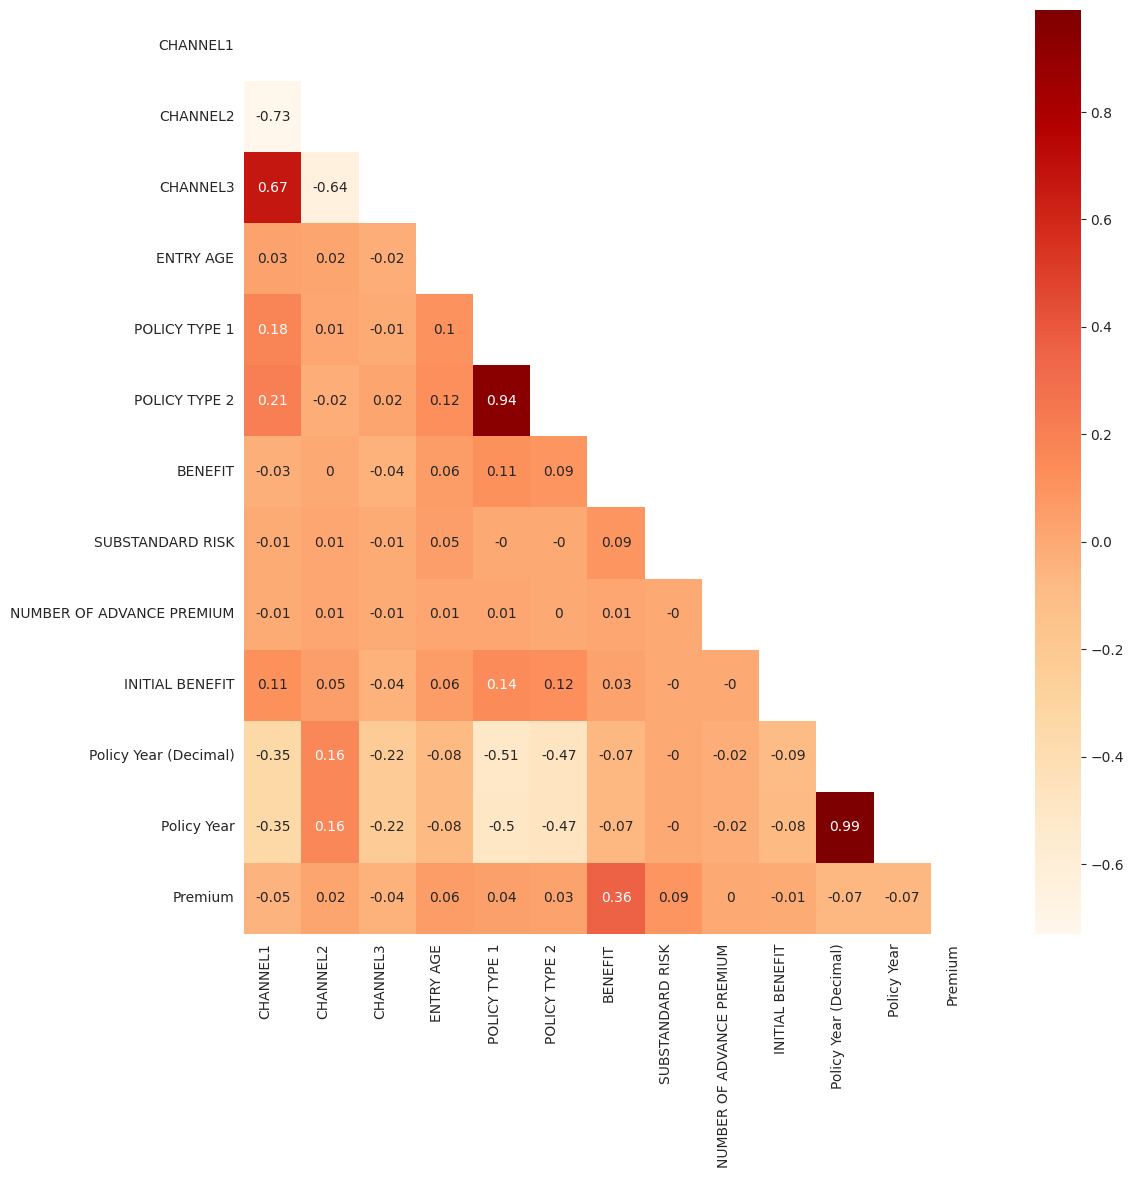

In [24]:
corr_matrix = X_train_numeric.corr().round(2)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(12, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

ax = sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='OrRd')

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha='right', rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

In [25]:
correlation_threshold = 0.5

highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

In [26]:
highly_correlated_features

{'CHANNEL2',
 'CHANNEL3',
 'POLICY TYPE 2',
 'Policy Year',
 'Policy Year (Decimal)'}

## Chi-Squared

A threshold value of 0.05 was used to determine feature significance. Based on this threshold, feature with p-value greater than 0.05 were considered less significant.

In [27]:
bool_columns = X_train_nom.select_dtypes(include='bool').columns
X_train_nom[bool_columns] = X[bool_columns].astype(str)

In [28]:
X_train_nom.isnull().sum()

SEX                     0
POLICY TYPE 3           0
PAYMENT MODE            0
NON LAPSE GUARANTEED    0
Full Benefit?           0
dtype: int64

In [29]:
X_train_nom.isnull().sum()

SEX                     0
POLICY TYPE 3           0
PAYMENT MODE            0
NON LAPSE GUARANTEED    0
Full Benefit?           0
dtype: int64

In [30]:
le = LabelEncoder()
X_train_nom_encoded = pd.DataFrame()
X_train_nom_encoded = X_train_nom.copy()

In [31]:
for col in X_train_nom.columns:
    X_train_nom_encoded[col] = le.fit_transform(X_train_nom[col])

In [32]:
X_train_nom_encoded

,SEX,POLICY TYPE 3,PAYMENT MODE,NON LAPSE GUARANTEED,Full Benefit?
86454,0,2,1,3,0
133444,1,2,1,3,0
94956,0,2,1,3,0
33160,1,0,1,3,0
80997,1,2,1,3,0
...,...,...,...,...,...
134275,1,0,1,3,0
115638,1,4,1,3,0
148127,1,2,1,3,0
165308,0,0,1,3,0


In [33]:
chi_score = chi2(X_train_nom_encoded, y_train)
chi_score

(array([7.12302930e+00, 2.03801647e+03, 1.11844906e+02, 8.08517024e-03,
        9.06519115e+01]),
 array([7.61000153e-03, 0.00000000e+00, 3.86384300e-26, 9.28352715e-01,
        1.71306471e-21]))

In [34]:
chi2_score_series = pd.Series(chi_score[0], index = X_train_nom_encoded.columns).sort_values(ascending = False)
p_value_series =  pd.Series(chi_score[1], index = X_train_nom_encoded.columns)

In [35]:
p_value_series

SEX                     7.610002e-03
POLICY TYPE 3           0.000000e+00
PAYMENT MODE            3.863843e-26
NON LAPSE GUARANTEED    9.283527e-01
Full Benefit?           1.713065e-21
dtype: float64

In [36]:
chi2_score_series

POLICY TYPE 3           2038.016465
PAYMENT MODE             111.844906
Full Benefit?             90.651911
SEX                        7.123029
NON LAPSE GUARANTEED       0.008085
dtype: float64

<Axes: >

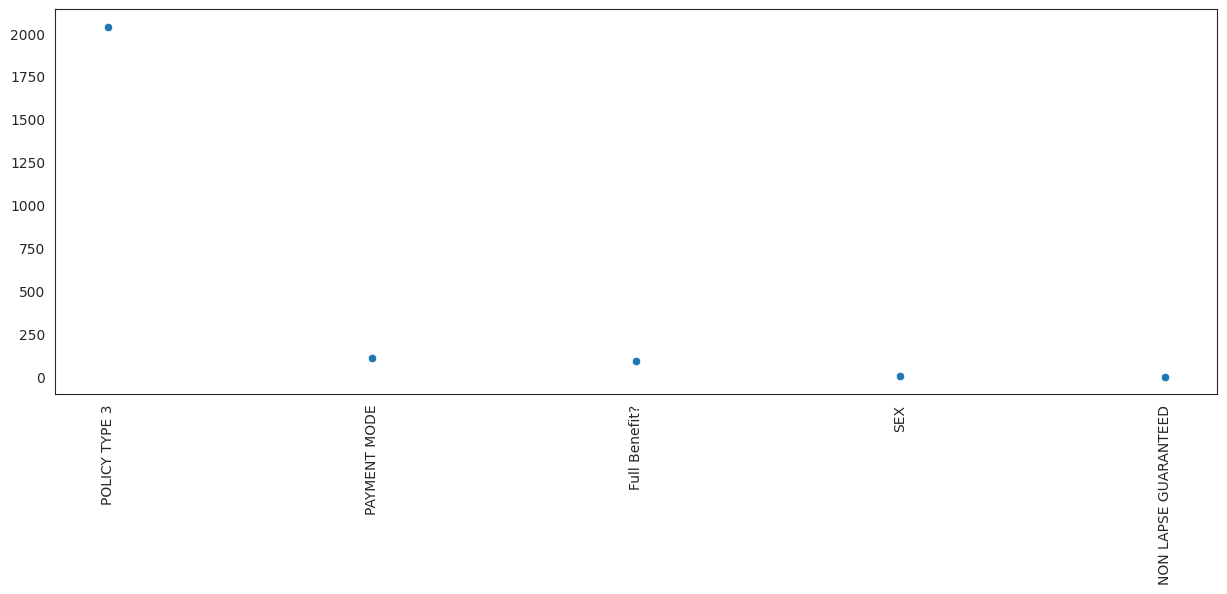

In [37]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.scatterplot(x=chi2_score_series.index, y=chi2_score_series.values)

<Axes: >

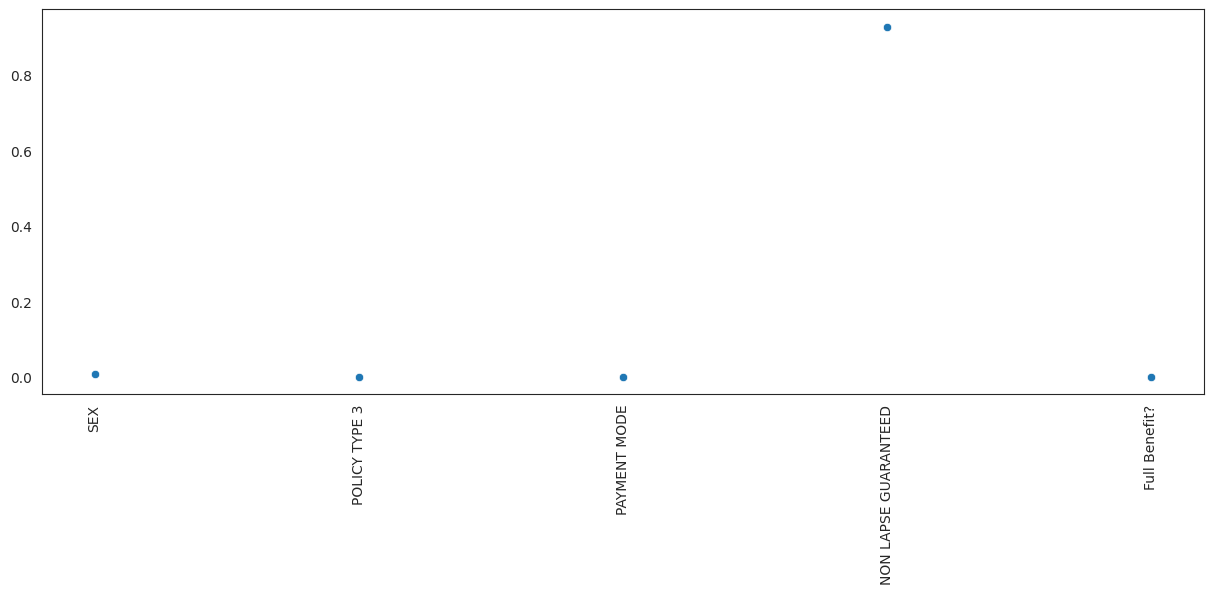

In [38]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.scatterplot(x=p_value_series.index, y=p_value_series.values)

In [39]:
significance_threshold = 0.05
features_to_drop = p_value_series[p_value_series > significance_threshold].index.tolist()

In [40]:
features_to_drop

['NON LAPSE GUARANTEED']

In [41]:
X_train_selected = X_train.drop(columns=highly_correlated_features)

In [42]:
X_test_selected = X_test.drop(columns=highly_correlated_features)

In [43]:
X_train_selected = X_train_selected.drop(columns=features_to_drop)

In [44]:
X_test_selected = X_test_selected.drop(columns=features_to_drop)

In [45]:
print("Remaining Features X train:")
print(X_train_selected.columns)

Remaining Features X train:
Index(['CHANNEL1', 'ENTRY AGE', 'SEX', 'POLICY TYPE 1', 'POLICY TYPE 3',
       'PAYMENT MODE', 'BENEFIT', 'SUBSTANDARD RISK',
       'NUMBER OF ADVANCE PREMIUM', 'INITIAL BENEFIT', 'Full Benefit?',
       'Premium'],
      dtype='object')


# Statistically Feature Selected Model

In this study, we consider three powerful ensemble learning algorithms Random Forest, CatBoost and XG Boost.

In [46]:
X_combined = pd.concat([X_train_selected, X_test_selected], axis=0)

In [47]:
X_combined_encoded = pd.get_dummies(X_combined)

In [48]:
X_train_encoded = X_combined_encoded.iloc[:len(X_train_selected)]
X_test_encoded = X_combined_encoded.iloc[len(X_train_selected):]

In [49]:
X_train_encoded

,CHANNEL1,ENTRY AGE,POLICY TYPE 1,BENEFIT,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Premium,SEX_F,SEX_M,...,POLICY TYPE 3_C,POLICY TYPE 3_D,POLICY TYPE 3_E,PAYMENT MODE_Annually,PAYMENT MODE_Monthly,PAYMENT MODE_Quaterly,PAYMENT MODE_Semiannually,PAYMENT MODE_Single Premium,Full Benefit?_N,Full Benefit?_Y
86454,2,26,3,350.0,0.0,0,0.0,432.0,True,False,...,True,False,False,False,True,False,False,False,True,False
133444,6,23,3,40.0,0.0,0,0.0,432.0,False,True,...,True,False,False,False,True,False,False,False,True,False
94956,2,36,3,100.0,0.0,0,0.0,432.0,True,False,...,True,False,False,False,True,False,False,False,True,False
33160,2,52,8,60000.0,0.0,0,0.0,5880.0,False,True,...,False,False,False,False,True,False,False,False,True,False
80997,2,30,3,180.0,0.0,0,0.0,432.0,False,True,...,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134275,6,29,3,10000.0,0.0,0,0.0,444.0,False,True,...,False,False,False,False,True,False,False,False,True,False
115638,5,43,4,1000.0,0.0,0,0.0,3.0,False,True,...,False,False,True,False,True,False,False,False,True,False
148127,6,44,3,20000.0,0.0,0,0.0,432.0,False,True,...,True,False,False,False,True,False,False,False,True,False
165308,6,44,7,20000.0,0.0,0,0.0,215.0,True,False,...,False,False,False,False,True,False,False,False,True,False


In [50]:
X_test_encoded

,CHANNEL1,ENTRY AGE,POLICY TYPE 1,BENEFIT,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Premium,SEX_F,SEX_M,...,POLICY TYPE 3_C,POLICY TYPE 3_D,POLICY TYPE 3_E,PAYMENT MODE_Annually,PAYMENT MODE_Monthly,PAYMENT MODE_Quaterly,PAYMENT MODE_Semiannually,PAYMENT MODE_Single Premium,Full Benefit?_N,Full Benefit?_Y
19747,2,52,3,100.0,0.0,0,0.0,432.0,True,False,...,True,False,False,False,True,False,False,False,True,False
138578,6,57,6,2500.0,0.0,0,0.0,28.0,False,True,...,False,False,True,False,True,False,False,False,True,False
151425,6,40,3,13000.0,0.0,0,0.0,3200.0,False,True,...,False,True,False,True,False,False,False,False,True,False
95441,2,55,3,40.0,0.0,0,0.0,432.0,True,False,...,True,False,False,False,True,False,False,False,True,False
66891,2,43,3,33800.0,0.0,0,0.0,400.0,False,True,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142108,6,37,6,50000.0,0.0,0,0.0,84.0,False,True,...,False,False,False,False,True,False,False,False,True,False
159251,6,35,3,34.0,0.0,0,0.0,432.0,False,True,...,True,False,False,False,True,False,False,False,True,False
127534,6,26,3,20000.0,0.0,0,0.0,432.0,True,False,...,False,False,False,False,True,False,False,False,True,False
135321,6,42,3,4000.0,0.0,0,0.0,432.0,False,True,...,True,False,False,False,True,False,False,False,True,False


In [51]:
y_test.value_counts()

POLICY STATUS
1    19781
0    13155
Name: count, dtype: int64

In [52]:
y_train.value_counts()

POLICY STATUS
1    79084
0    52659
Name: count, dtype: int64

In [53]:
class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(class_ratio)

0.6658616154974457


## Evaluation Metrics of Random Forest

In [54]:
class_weight_value = {0: 1, 1: class_ratio}

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_value)

rf_classifier.fit(X_train_encoded, y_train)

y_pred_rf = rf_classifier.predict(X_test_encoded)

print("Statistically Feature Selected Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Statistically Feature Selected Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61     13155
           1       0.74      0.74      0.74     19781

    accuracy                           0.69     32936
   macro avg       0.68      0.68      0.68     32936
weighted avg       0.69      0.69      0.69     32936



In [55]:
num_folds = 10

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(rf_classifier, X_combined_encoded, y, cv=cv, scoring='f1')

print("Cross-Validation Scores:", scores)

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev)

Cross-Validation Scores: [0.58541893 0.58734099 0.58635162 0.58371228 0.58139414 0.58398679
 0.581024   0.58530252 0.6017681  0.58744279]
Mean Cross-Validation Score: 0.5863742177278211
Standard Deviation of Cross-Validation Scores: 0.005543658154733258


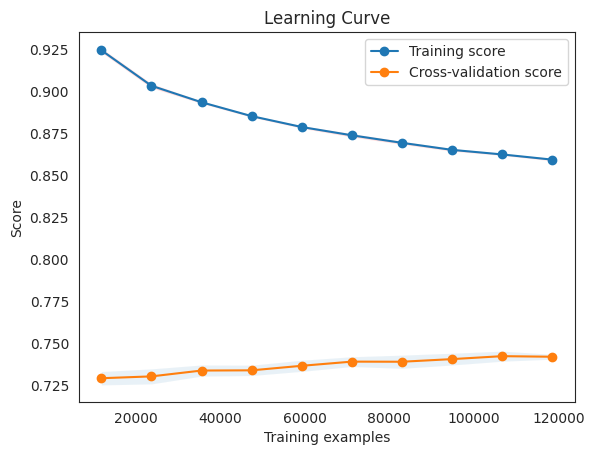

In [56]:
def plot_learning_curve(estimator, x, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    sns.set_style("white")
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(rf_classifier, X_train_encoded, y_train, cv=10, n_jobs=-1)
plt.show()

In [57]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Statistically Feature Selected Random Forest Accuracy: {rf_accuracy:.4f}')
rf_precision = precision_score(y_test, y_pred_rf)
print(f'Statistically Feature Selected Random Forest Precision: {rf_precision:.4f}')
rf_recall = recall_score(y_test, y_pred_rf)
print(f'Statistically Feature Selected Random Forest Recall: {rf_recall:.4f}')
rf_f_measure = f1_score(y_test, y_pred_rf)
print(f'Statistically Feature Selected Random Forest F-measure: {rf_f_measure:.4f}')

Statistically Feature Selected Random Forest Accuracy: 0.6880
Statistically Feature Selected Random Forest Precision: 0.7420
Statistically Feature Selected Random Forest Recall: 0.7366
Statistically Feature Selected Random Forest F-measure: 0.7393


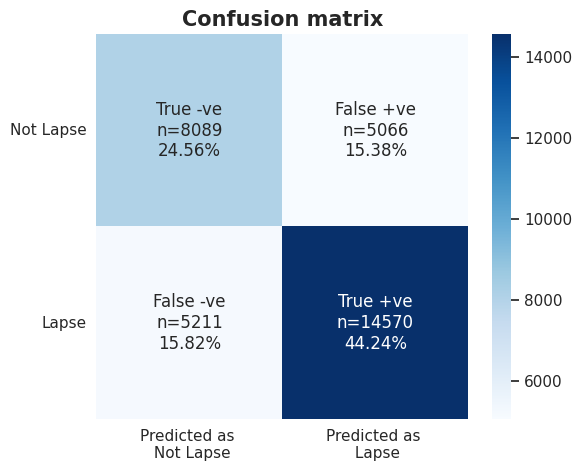

In [58]:
predictions = rf_classifier.predict(X_test_encoded)
rf_cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True -ve','False +ve','False -ve','True +ve']
group_counts = ['n={0:0.0f}'.format(value) for value in rf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in rf_cf_matrix.flatten()/np.sum(rf_cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

yticklabels=['Not Lapse','Lapse']
xticklabels=['Predicted as \n Not Lapse','Predicted as \n Lapse']

fix, ax = plt.subplots(figsize=(6,5))

sns.set()
ax = sns.heatmap(rf_cf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

## Evaluation Metrics of Cat Boost

In [59]:
class_weight_value = [1, class_ratio]
cat_classifier = CatBoostClassifier(
    iterations=300,          # number of boosting rounds
    depth=6,                  # max depth of trees
    learning_rate=0.05,       # step size shrinkage
    loss_function='Logloss',  # binary classification
    eval_metric='AUC',        # monitor AUC during training
    class_weights=class_weight_value,
    random_seed=42,
    verbose=False             # suppress per-iteration output
)
cat_classifier.fit(X_train_encoded, y_train)

y_pred_cat = cat_classifier.predict(X_test_encoded)

print("Statistically Feature Selected CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))

Statistically Feature Selected CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65     13155
           1       0.77      0.75      0.76     19781

    accuracy                           0.72     32936
   macro avg       0.70      0.71      0.71     32936
weighted avg       0.72      0.72      0.72     32936



In [60]:
num_folds = 10

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(cat_classifier, X_combined_encoded, y, cv=cv, scoring='f1')

print("Cross-Validation Scores:", scores)

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev)

Cross-Validation Scores: [0.57072807 0.57793867 0.5808245  0.5677843  0.56474627 0.56650062
 0.56366376 0.54773066 0.56776811 0.55577151]
Mean Cross-Validation Score: 0.5663456468722885
Standard Deviation of Cross-Validation Scores: 0.009140234670819614


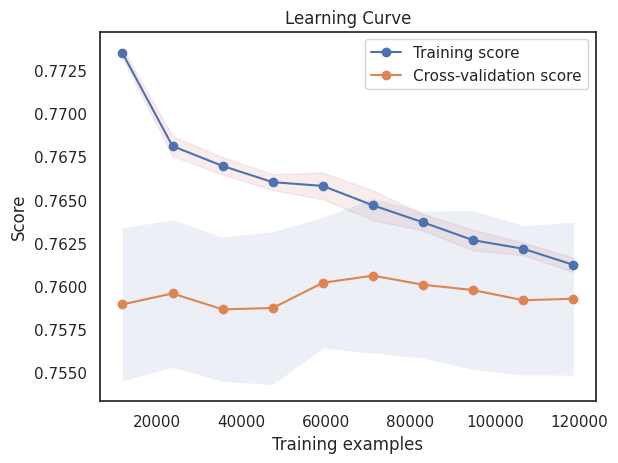

In [61]:
def plot_learning_curve(estimator, x, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    sns.set_style("white")
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(cat_classifier, X_train_encoded, y_train, cv=10, n_jobs=-1)
plt.show()

In [62]:
cat_accuracy = accuracy_score(y_test, y_pred_cat)
print(f'Statistically Feature Selected Random Forest Accuracy: {cat_accuracy:.4f}')
cat_precision = precision_score(y_test, y_pred_cat)
print(f'Statistically Feature Selected Random Forest Precision: {cat_precision:.4f}')
cat_recall = recall_score(y_test, y_pred_cat)
print(f'Statistically Feature Selected Random Forest Recall: {cat_recall:.4f}')
cat_f_measure = f1_score(y_test, y_pred_cat)
print(f'Statistically Feature Selected Random Forest F-measure: {cat_f_measure:.4f}')

Statistically Feature Selected Random Forest Accuracy: 0.7154
Statistically Feature Selected Random Forest Precision: 0.7711
Statistically Feature Selected Random Forest Recall: 0.7484
Statistically Feature Selected Random Forest F-measure: 0.7596


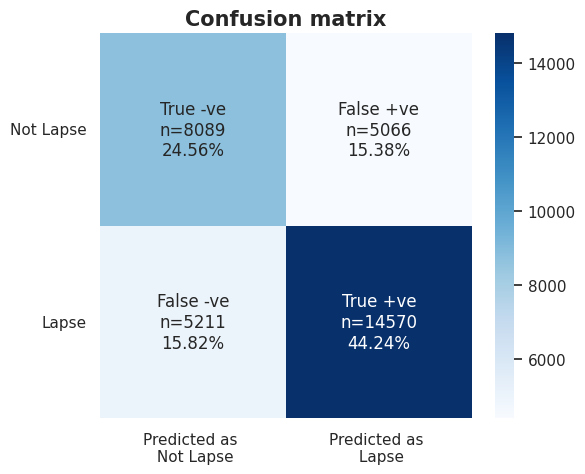

In [63]:
predictions = cat_classifier.predict(X_test_encoded)
cat_cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True -ve','False +ve','False -ve','True +ve']
group_counts = ['n={0:0.0f}'.format(value) for value in rf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in rf_cf_matrix.flatten()/np.sum(rf_cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

yticklabels=['Not Lapse','Lapse']
xticklabels=['Predicted as \n Not Lapse','Predicted as \n Lapse']

fix, ax = plt.subplots(figsize=(6,5))

sns.set()
ax = sns.heatmap(cat_cf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

## Evaluation Metrics of XG Boost

In [64]:
scale_pos_weight_value = class_ratio

xg_classifier = XGBClassifier(booster='gbtree', n_jobs=-1, use_label_encoder=False, scale_pos_weight=scale_pos_weight_value)

xg_classifier.fit(X_train_encoded, y_train)

y_pred_xg = xg_classifier.predict(X_test_encoded)

print("Statistically Feature Selected XG Boost Classification Report:")
print(classification_report(y_test, y_pred_xg))

Statistically Feature Selected XG Boost Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     13155
           1       0.77      0.76      0.76     19781

    accuracy                           0.72     32936
   macro avg       0.71      0.71      0.71     32936
weighted avg       0.72      0.72      0.72     32936



In [65]:
num_folds = 10

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(xg_classifier, X_combined_encoded, y, cv=cv, scoring='f1')

print("Cross-Validation Scores:", scores)

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev)

Cross-Validation Scores: [0.55288618 0.55157319 0.55536238 0.56396193 0.55803838 0.55383778
 0.55262727 0.55668983 0.56409981 0.55739651]
Mean Cross-Validation Score: 0.556647327117472
Standard Deviation of Cross-Validation Scores: 0.00420879521167296


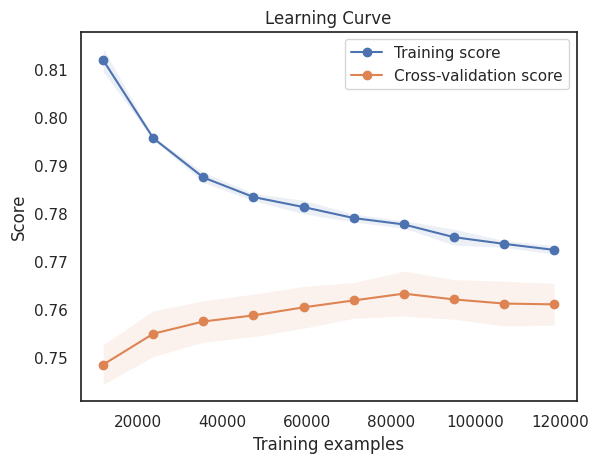

In [66]:
def plot_learning_curve(estimator, x, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    sns.set_style("white")
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(xg_classifier, X_train_encoded, y_train, cv=10, n_jobs=-1)
plt.show()

In [67]:
xgb_accuracy = accuracy_score(y_test, y_pred_xg)
print(f'Statistically Feature Selected XG Boost Accuracy: {xgb_accuracy:.4f}')
xgb_precision = precision_score(y_test, y_pred_xg)
print(f'Statistically Feature Selected XG Boost Precision: {xgb_precision:.4f}')
xgb_recall = recall_score(y_test, y_pred_xg)
print(f'Statistically Feature Selected XG Boost Recall: {xgb_recall:.4f}')
xgb_f_measure = f1_score(y_test, y_pred_xg)
print(f'Statistically Feature Selected XG Boost F-measure: {xgb_f_measure:.4f}')

Statistically Feature Selected XG Boost Accuracy: 0.7171
Statistically Feature Selected XG Boost Precision: 0.7694
Statistically Feature Selected XG Boost Recall: 0.7555
Statistically Feature Selected XG Boost F-measure: 0.7624


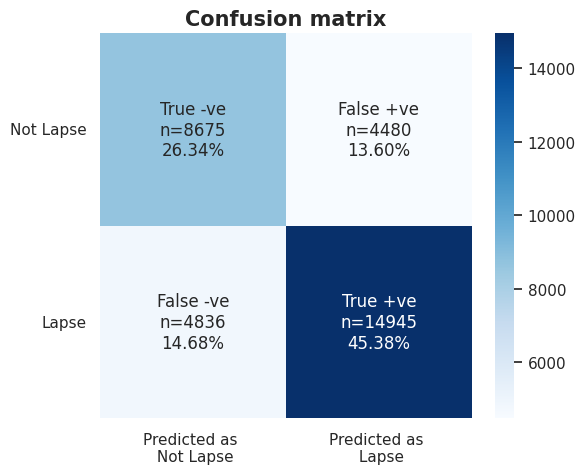

In [68]:
predictions = xg_classifier.predict(X_test_encoded)
xg_cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True -ve','False +ve','False -ve','True +ve']
group_counts = ['n={0:0.0f}'.format(value) for value in xg_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xg_cf_matrix.flatten()/np.sum(xg_cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

yticklabels=['Not Lapse','Lapse']
xticklabels=['Predicted as \n Not Lapse','Predicted as \n Lapse']


fix, ax = plt.subplots(figsize=(6,5))

sns.set()
ax = sns.heatmap(xg_cf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

# XG Boost Feature Selected

In this context of the study, XG Boost's feature importance scores were utilized to rank features based on their predictive power. Here, threshold value was taken as median of feature importance.

In [69]:
X_train.dtypes

CHANNEL1                       int64
CHANNEL2                       int64
CHANNEL3                       int64
ENTRY AGE                      int64
SEX                           object
POLICY TYPE 1                  int64
POLICY TYPE 2                  int64
POLICY TYPE 3                 object
PAYMENT MODE                  object
BENEFIT                      float64
NON LAPSE GUARANTEED          object
SUBSTANDARD RISK             float64
NUMBER OF ADVANCE PREMIUM      int64
INITIAL BENEFIT              float64
Full Benefit?                 object
Policy Year (Decimal)        float64
Policy Year                    int64
Premium                      float64
dtype: object

In [70]:
label_encoder = LabelEncoder()
X_train_encodedxgb = X_train.copy()

In [71]:
X_test_encodedxgb = X_test.copy()

In [72]:
for col in X_train_nom:
    X_test_encodedxgb[col] = label_encoder.fit_transform(X_test[col])

In [73]:
for col in X_train_nom:
    X_train_encodedxgb[col] = label_encoder.fit_transform(X_train[col])

In [74]:
scale_pos_weight_value = class_ratio
xgb_model = XGBClassifier(booster='gbtree', n_jobs=-1, use_label_encoder=False, scale_pos_weight=scale_pos_weight_value)
xgb_model.fit(X_train_encodedxgb, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [75]:
feature_importance = xgb_model.feature_importances_

In [76]:
for feature, importance in zip(X_train_encodedxgb.columns, feature_importance):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: CHANNEL1, Importance: 0.05942646041512489
Feature: CHANNEL2, Importance: 0.05167601257562637
Feature: CHANNEL3, Importance: 0.0255538672208786
Feature: ENTRY AGE, Importance: 0.018609246239066124
Feature: SEX, Importance: 0.009539107792079449
Feature: POLICY TYPE 1, Importance: 0.10133644193410873
Feature: POLICY TYPE 2, Importance: 0.06702025979757309
Feature: POLICY TYPE 3, Importance: 0.08228440582752228
Feature: PAYMENT MODE, Importance: 0.14689266681671143
Feature: BENEFIT, Importance: 0.021995805203914642
Feature: NON LAPSE GUARANTEED, Importance: 0.19678731262683868
Feature: SUBSTANDARD RISK, Importance: 0.005677183624356985
Feature: NUMBER OF ADVANCE PREMIUM, Importance: 0.012929236516356468
Feature: INITIAL BENEFIT, Importance: 0.0
Feature: Full Benefit?, Importance: 0.0
Feature: Policy Year (Decimal), Importance: 0.16454902291297913
Feature: Policy Year, Importance: 0.0
Feature: Premium, Importance: 0.03572292625904083


In [77]:
median_importance = np.median(feature_importance)

In [78]:
median_importance

0.030638397

In [79]:
threshold = median_importance 

top_features_indices = np.where(feature_importance > threshold)[0]

In [80]:
top_features_indices

array([ 0,  1,  5,  6,  7,  8, 10, 15, 17])

In [81]:
top_features = X_train_encodedxgb.columns[top_features_indices]

In [82]:
X_train_xgb_selected = X_train[top_features]

In [83]:
print(X_train_xgb_selected.columns)

Index(['CHANNEL1', 'CHANNEL2', 'POLICY TYPE 1', 'POLICY TYPE 2',
       'POLICY TYPE 3', 'PAYMENT MODE', 'NON LAPSE GUARANTEED',
       'Policy Year (Decimal)', 'Premium'],
      dtype='object')


In [84]:
X_test_xgb_selected = X_test[top_features]

In [85]:
print(X_test_xgb_selected)

        CHANNEL1  CHANNEL2  POLICY TYPE 1  POLICY TYPE 2 POLICY TYPE 3  \
19747          2         3              3             17             C   
138578         6         2              6             38             E   
151425         6         2              3              6             D   
95441          2         3              3             12             C   
66891          2         3              3              5             A   
...          ...       ...            ...            ...           ...   
142108         6         2              6             35             A   
159251         6         2              3              9             C   
127534         6         2              3              5             A   
135321         6         2              3             13             C   
24549          2         3              3              9             C   

        PAYMENT MODE NON LAPSE GUARANTEED  Policy Year (Decimal)  Premium  
19747        Monthly               

In [86]:
X_combined_xgb = pd.concat([X_train_xgb_selected, X_test_xgb_selected], axis=0)

In [87]:
X_combined_xgb_encoded = pd.get_dummies(X_combined_xgb)

In [88]:
X_combined_xgb_encoded = pd.get_dummies(X_combined_xgb)

In [89]:
X_train_xgb_encoded = X_combined_xgb_encoded.iloc[:len(X_train_xgb_selected)]
X_test_xgb_encoded = X_combined_xgb_encoded.iloc[len(X_train_xgb_selected):]

# XG Boost Feature Selected Model

In our study, two different feature selection technique is used statistical approach of feature selection that include Pearson's Correlation Coefficient and Chi-Squared and Feature Selection using XG Boost Feature Importance, followed by comparison of three powerful ensemble learning algorithms Random Forest, CatBoost and XGBoost.

## Evaluation Metrics of XG Boost Feature Selected Random Forest

In [90]:
class_weight_value = {0: 1, 1: class_ratio}

xgb_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_value)
xgb_rf_classifier.fit(X_train_xgb_encoded, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 0.6658616154974457},
                       random_state=42)

In [91]:
y_pred_xgb_rf = xgb_rf_classifier.predict(X_test_xgb_encoded)

print("XG Boost Feature Selected Random Forest Classification Report:")
print(classification_report(y_test, y_pred_xgb_rf))

XG Boost Feature Selected Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64     13155
           1       0.76      0.79      0.77     19781

    accuracy                           0.72     32936
   macro avg       0.71      0.71      0.71     32936
weighted avg       0.72      0.72      0.72     32936



In [92]:
num_folds = 10

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(xgb_rf_classifier, X_combined_encoded, y, cv=cv, scoring='f1')
print("Cross-Validation Scores:", scores)

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev)

Cross-Validation Scores: [0.58541893 0.58734099 0.58635162 0.58371228 0.58139414 0.58398679
 0.581024   0.58530252 0.6017681  0.58744279]
Mean Cross-Validation Score: 0.5863742177278211
Standard Deviation of Cross-Validation Scores: 0.005543658154733258


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


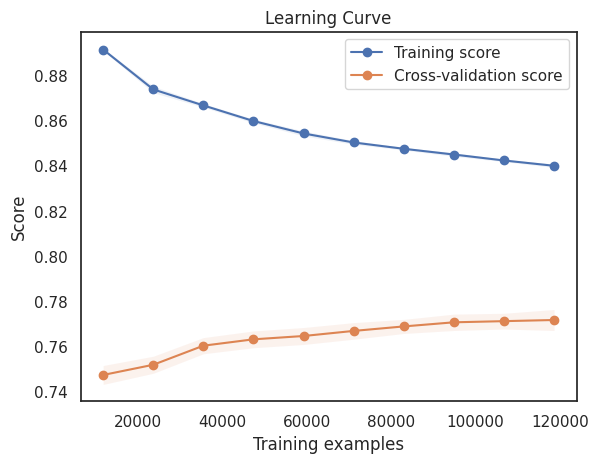

In [93]:
def plot_learning_curve(estimator, x, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    sns.set_style("white")
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(xgb_rf_classifier, X_train_xgb_encoded, y_train, cv=10, n_jobs=-1)
plt.show()

In [94]:
xgb_rf_accuracy = accuracy_score(y_test, y_pred_xgb_rf)
print(f'XG Boost Feature Selected Random Forest Accuracy: {xgb_rf_accuracy:.4f}')
xgb_rf_precision = precision_score(y_test, y_pred_xgb_rf)
print(f'XG Boost Feature Selected Random Forest Precision: {xgb_rf_precision:.4f}')
xgb_rf_recall = recall_score(y_test, y_pred_xgb_rf)
print(f'XG Boost Feature Selected Random Forest Recall: {xgb_rf_recall:.4f}')
xgb_rf_f_measure = f1_score(y_test, y_pred_xgb_rf)
print(f'XG Boost Feature Selected Random Forest F-measure: {xgb_rf_f_measure:.4f}')

XG Boost Feature Selected Random Forest Accuracy: 0.7235
XG Boost Feature Selected Random Forest Precision: 0.7608
XG Boost Feature Selected Random Forest Recall: 0.7870
XG Boost Feature Selected Random Forest F-measure: 0.7737


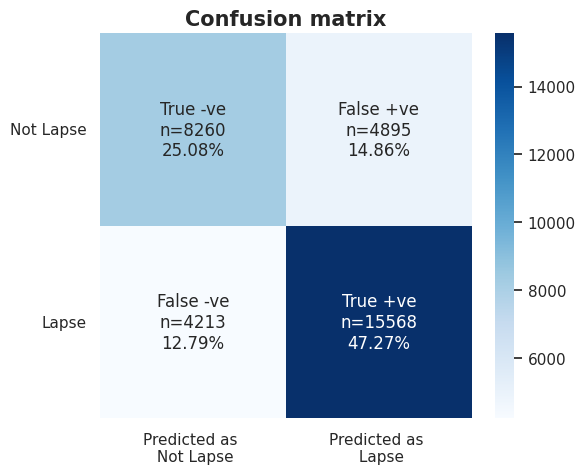

In [95]:
predictions = xgb_rf_classifier.predict(X_test_xgb_encoded)
xg_rf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True -ve','False +ve','False -ve','True +ve']
group_counts = ['n={0:0.0f}'.format(value) for value in xg_rf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xg_rf_matrix.flatten()/np.sum(xg_rf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

yticklabels=['Not Lapse','Lapse']
xticklabels=['Predicted as \n Not Lapse','Predicted as \n Lapse']

fix, ax = plt.subplots(figsize=(6,5))

sns.set()
ax = sns.heatmap(xg_rf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

## Evaluation Metrics of XG Boost Feature Selected Cat Boost

In [96]:
class_weight_value = [1, class_ratio]
xg_cat_classifier = CatBoostClassifier(
    iterations=300,          # number of boosting rounds
    depth=6,                  # max depth of trees
    learning_rate=0.05,       # step size shrinkage
    loss_function='Logloss',  # binary classification
    eval_metric='AUC',        # monitor AUC during training
    class_weights=class_weight_value,
    random_seed=42,
    verbose=False             # suppress per-iteration output
)
xg_cat_classifier.fit(X_train_xgb_encoded, y_train)

y_pred_xg_cat = xg_cat_classifier.predict(X_test_xgb_encoded)

print("Statistically Feature Selected CatBoost Classification Report:")
print(classification_report(y_test, y_pred_xg_cat))

Statistically Feature Selected CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66     13155
           1       0.76      0.82      0.79     19781

    accuracy                           0.74     32936
   macro avg       0.73      0.72      0.72     32936
weighted avg       0.74      0.74      0.74     32936



In [97]:
num_folds = 10

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(xg_cat_classifier, X_combined_encoded, y, cv=cv, scoring='f1')
print("Cross-Validation Scores:", scores)

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev)

Cross-Validation Scores: [0.57072807 0.57793867 0.5808245  0.5677843  0.56474627 0.56650062
 0.56366376 0.54773066 0.56776811 0.55577151]
Mean Cross-Validation Score: 0.5663456468722885
Standard Deviation of Cross-Validation Scores: 0.009140234670819614


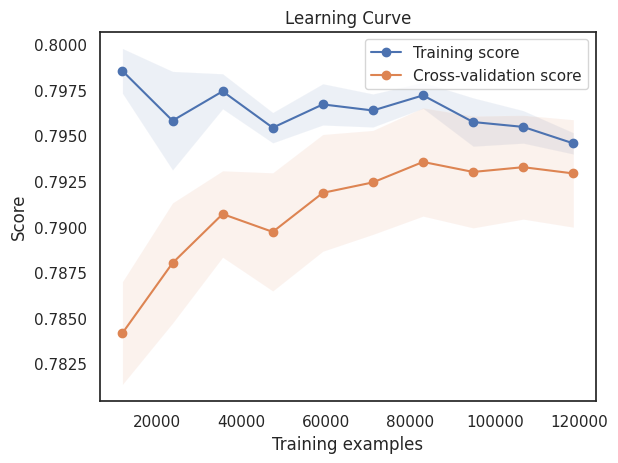

In [98]:
def plot_learning_curve(estimator, x, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    sns.set_style("white")
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(xg_cat_classifier, X_train_xgb_encoded, y_train, cv=10, n_jobs=-1)
plt.show()

In [99]:
xgb_cat_accuracy = accuracy_score(y_test, y_pred_xg_cat)
print(f'XG Boost Feature Selected Cat Boost Accuracy: {xgb_cat_accuracy:.4f}')
xgb_cat_precision = precision_score(y_test, y_pred_xg_cat)
print(f'XG Boost Feature Selected Cat Boost Precision: {xgb_cat_precision:.4f}')
xgb_cat_recall = recall_score(y_test, y_pred_xg_cat)
print(f'XG Boost Feature Selected Cat Boost Recall: {xgb_cat_recall:.4f}')
xgb_cat_f_measure = f1_score(y_test, y_pred_xg_cat)
print(f'XG Boost Feature Selected Cat Boost F-measure: {xgb_cat_f_measure:.4f}')

XG Boost Feature Selected Cat Boost Accuracy: 0.7413
XG Boost Feature Selected Cat Boost Precision: 0.7649
XG Boost Feature Selected Cat Boost Recall: 0.8217
XG Boost Feature Selected Cat Boost F-measure: 0.7923


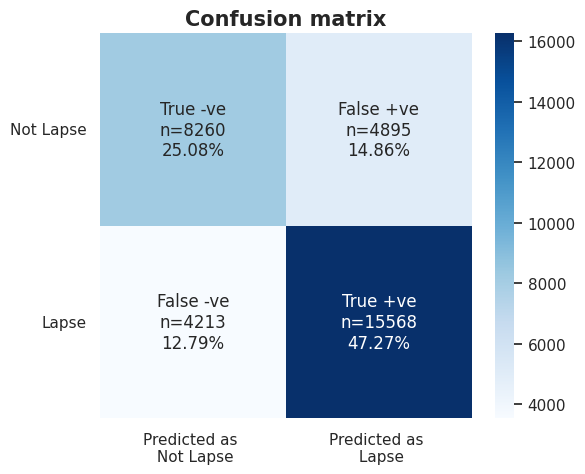

In [100]:
predictions = xg_cat_classifier.predict(X_test_xgb_encoded)
xg_cat_matrix = confusion_matrix(y_test, predictions)

group_names = ['True -ve','False +ve','False -ve','True +ve']
group_counts = ['n={0:0.0f}'.format(value) for value in xg_rf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xg_rf_matrix.flatten()/np.sum(xg_rf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

yticklabels=['Not Lapse','Lapse']
xticklabels=['Predicted as \n Not Lapse','Predicted as \n Lapse']

fix, ax = plt.subplots(figsize=(6,5))

sns.set()
ax = sns.heatmap(xg_cat_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

## Evaluation Metrics of XG Boost Feature Selected XG Boost

In [101]:
scale_pos_weight_value = class_ratio
xgb_xgb_classifier = XGBClassifier(booster='gbtree', n_jobs=-1, use_label_encoder=False, scale_pos_weight=scale_pos_weight_value)
xgb_xgb_classifier.fit(X_train_xgb_encoded, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [102]:
y_pred_xgb_xgb = xgb_xgb_classifier.predict(X_test_xgb_encoded)

print("XG Boost Feature Fusion XG Boost Classification Report:")
print(classification_report(y_test, y_pred_xgb_xgb))

XG Boost Feature Fusion XG Boost Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66     13155
           1       0.77      0.81      0.79     19781

    accuracy                           0.74     32936
   macro avg       0.73      0.72      0.72     32936
weighted avg       0.74      0.74      0.74     32936



In [103]:
num_folds = 10

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(xgb_xgb_classifier, X_combined_xgb_encoded, y, cv=cv, scoring='f1')

print("Cross-Validation Scores:", scores)

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Cross-Validation Score:", mean_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev)

Cross-Validation Scores: [0.55289768 0.54512256 0.54085194 0.54285714 0.55140496 0.55807135
 0.54794218 0.54397537 0.55155456 0.55616823]
Mean Cross-Validation Score: 0.5490845977720976
Standard Deviation of Cross-Validation Scores: 0.005537408587626283


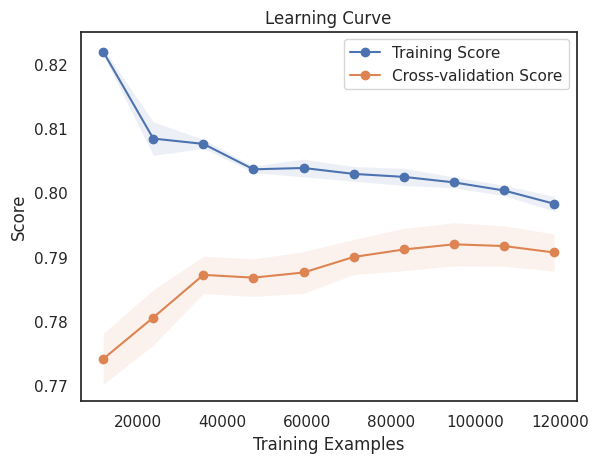

In [104]:
def plot_learning_curve(estimator, x, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    sns.set_style("white")
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation Score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(xgb_xgb_classifier, X_train_xgb_encoded, y_train, cv=10, n_jobs=-1)
plt.show()

In [105]:
xgb_xgb_accuracy = accuracy_score(y_test, y_pred_xgb_xgb)
print(f'XG Boost Feature Selected XG Boost Accuracy: {xgb_xgb_accuracy:.4f}')
xgb_xgb_precision = precision_score(y_test, y_pred_xgb_xgb)
print(f'XG Boost Feature Selected XG Boost Precision: {xgb_xgb_precision:.4f}')
xgb_xgb_recall = recall_score(y_test, y_pred_xgb_xgb)
print(f'XG Boost Feature Selected XG Boost Recall: {xgb_xgb_recall:.4f}')
xgb_xgb_f_measure = f1_score(y_test, y_pred_xgb_xgb)
print(f'XG Boost Feature Selected XG Boost F-measure: {xgb_xgb_f_measure:.4f}')

XG Boost Feature Selected XG Boost Accuracy: 0.7386
XG Boost Feature Selected XG Boost Precision: 0.7700
XG Boost Feature Selected XG Boost Recall: 0.8053
XG Boost Feature Selected XG Boost F-measure: 0.7873


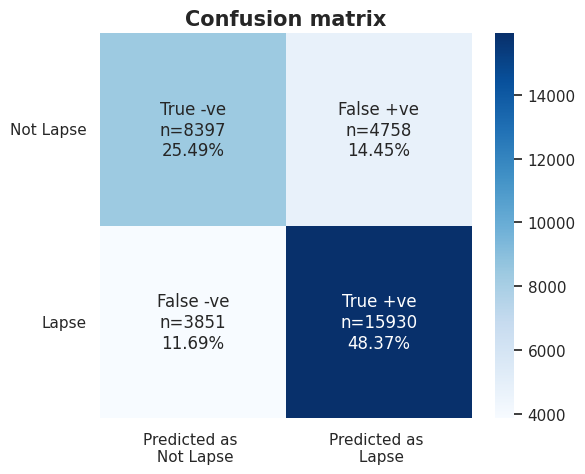

In [106]:
predictions = xgb_xgb_classifier.predict(X_test_xgb_encoded)
xg_xgb_matrix = confusion_matrix(y_test, predictions)

group_names = ['True -ve','False +ve','False -ve','True +ve']
group_counts = ['n={0:0.0f}'.format(value) for value in xg_xgb_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xg_xgb_matrix.flatten()/np.sum(xg_xgb_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

yticklabels=['Not Lapse','Lapse']
xticklabels=['Predicted as \n Not Lapse','Predicted as \n Lapse']


fix, ax = plt.subplots(figsize=(6,5))

sns.set()
ax = sns.heatmap(xg_xgb_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

# Comparative Analysis

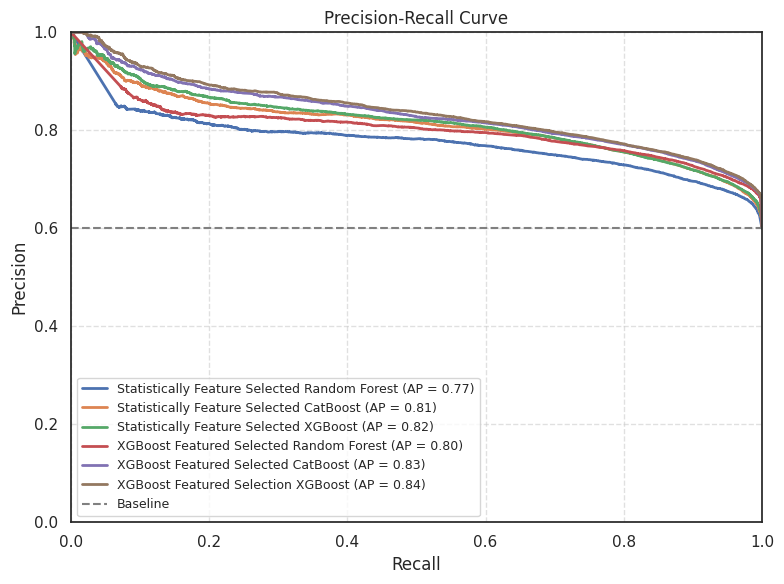

In [107]:
rf_probs = rf_classifier.predict_proba(X_test_encoded)[:, 1]
cat_probs = cat_classifier.predict_proba(X_test_encoded)[:, 1]
xgb_probs = xg_classifier.predict_proba(X_test_encoded)[:, 1]

xgb_rf_probs = xgb_rf_classifier.predict_proba(X_test_xgb_encoded)[:, 1]
xgb_cat_probs = xg_cat_classifier.predict_proba(X_test_xgb_encoded)[:, 1]
xgb_xgb_probs = xgb_xgb_classifier.predict_proba(X_test_xgb_encoded)[:, 1]

rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_average_precision = average_precision_score(y_test, rf_probs)

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_average_precision = average_precision_score(y_test, xgb_probs)

cat_precision, cat_recall, _ = precision_recall_curve(y_test, cat_probs)
cat_average_precision = average_precision_score(y_test, cat_probs)

xgb_rf_precision, xgb_rf_recall, _ = precision_recall_curve(y_test, xgb_rf_probs)
xgb_rf_average_precision = average_precision_score(y_test, xgb_rf_probs)

xgb_cat_precision, xgb_cat_recall, _ = precision_recall_curve(y_test, xgb_cat_probs)
xgb_cat_average_precision = average_precision_score(y_test, xgb_cat_probs)

xgb_xgb_precision, xgb_xgb_recall, _ = precision_recall_curve(y_test, xgb_xgb_probs)
xgb_xgb_average_precision = average_precision_score(y_test, xgb_xgb_probs)

plt.figure(figsize=(8, 6))
sns.set_style("white")

plt.plot(rf_recall, rf_precision, label=f'Statistically Feature Selected Random Forest (AP = {rf_average_precision:.2f})', linewidth=2)
plt.plot(cat_recall, cat_precision, label=f'Statistically Feature Selected CatBoost (AP = {cat_average_precision:.2f})', linewidth=2)
plt.plot(xgb_recall, xgb_precision, label=f'Statistically Feature Selected XGBoost (AP = {xgb_average_precision:.2f})', linewidth=2)

plt.plot(xgb_rf_recall, xgb_rf_precision, label=f'XGBoost Featured Selected Random Forest (AP = {xgb_rf_average_precision:.2f})', linewidth=2)
plt.plot(xgb_cat_recall, xgb_cat_precision, label=f'XGBoost Featured Selected CatBoost (AP = {xgb_cat_average_precision:.2f})', linewidth=2)
plt.plot(xgb_xgb_recall, xgb_xgb_precision, label=f'XGBoost Featured Selection XGBoost (AP = {xgb_xgb_average_precision:.2f})', linewidth=2)

# Add baseline (average positive rate)
baseline = y_test.mean()
plt.plot([0, 1], [baseline, baseline], linestyle='--', color='gray', label='Baseline')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower left', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Features Extraction from the Best Model

In [108]:
feature_importance = xgb_xgb_classifier.feature_importances_

feature_names = X_train_xgb_encoded.columns

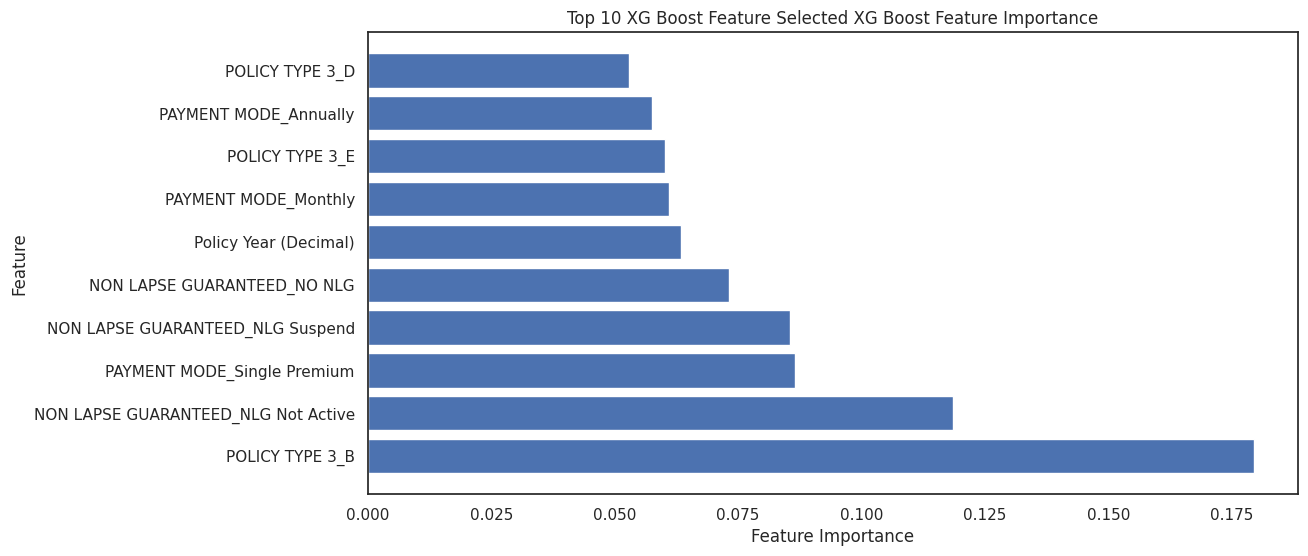

In [109]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 XG Boost Feature Selected XG Boost Feature Importance')
plt.show()

In [110]:
booster = xgb_xgb_classifier.get_booster()

feature_gain = booster.get_score(importance_type='gain')

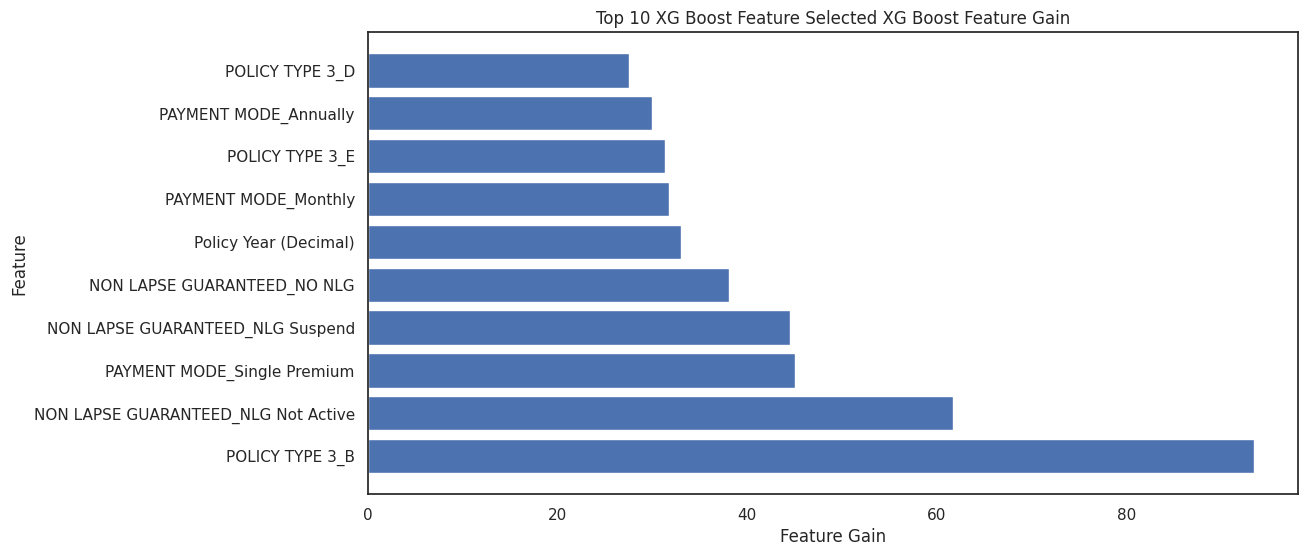

In [111]:
feature_gain_df = pd.DataFrame({'Feature': list(feature_gain.keys()), 'Gain': list(feature_gain.values())})
feature_gain_df = feature_gain_df.sort_values(by='Gain', ascending=False)

top_10_features_gain = feature_gain_df.head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10_features_gain['Feature'], top_10_features_gain['Gain'])
plt.xlabel('Feature Gain')
plt.ylabel('Feature')
plt.title('Top 10 XG Boost Feature Selected XG Boost Feature Gain')
plt.show()

# Conclusion and Future Work

Our comparative study analyzed Random Forest and XG Boost, both features selected from statistical approach and with XG Boost feature importance. Evaluation metrics such as accuracy, precision, recall and F-measure along with Precision-Recall curves, provide comprehensive insights into the effectiveness of our approach.

In conclusion, our study offers valuable insights into enhancing the predictive capabilities of Random Forest and XG Boost algorithm for predicting lapse in life insurance. By integrating XG Boost Feature Importance for feature selection, we have demonstrated significant improvements in model performance.

In addition to utilizing XG Boost's feature importance for feature selection, a potential enhancement to our methodology can be Recursive Feature Elimination (RFE). By integrating REF into feature selection, we can further refine the feature subset used by predictive models. The iterative approach allows us to systematically evaluate the contribution of each feature to the model's performance, thereby potentially improving predicting accuracy and reducing overfitting.